In [ ]:
!  pip install -q tensorflow-model-optimization

In [2]:
import tempfile
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras
import tensorflow_model_optimization as tfmot
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard
from tensorflow.keras.optimizers import Adam
import  argparse
from utils import dataset
from utils import display_sample,show_predictions,create_mask
from Models import unetModel
import os
import datetime
import numpy as np
from losses import custom_sparse_weighted_crossentropy

%load_ext tensorboard

## Build and evaluate base model

In [3]:
BATCH_SIZE=3
EPOCHS = 100
ClASSES=5 # Backgroud plus four lanes
lr=0.0001

In [4]:
data="/media/asad/8800F79D00F79104/lanes_data/20k_images/"
labels="/media/asad/8800F79D00F79104/lanes_data/20k_labels/"
lane_data=dataset(data,labels)
datasets=lane_data.load_dataset()

The Training Dataset contains 20000 images.
The Training labels contains 20000 images.
Training size 19000
Validation size 1000


2


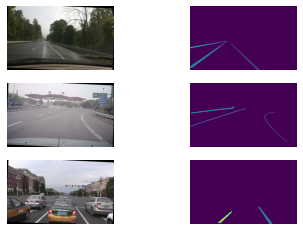

In [5]:
data=list(datasets["train"].take(1).as_numpy_iterator())
sample_image,sample_label=data[0][0],data[0][1]
display_sample([sample_image,sample_label])

In [6]:
model=unetModel()
unet=model.get_unet()
unet.trainable=True
unet.load_weights("/media/asad/8800F79D00F79104/best_unet_lane_20k_default_ce.h5")
loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True)
unet.compile(optimizer=Adam(learning_rate=lr), loss =loss,metrics=['accuracy'])   

In [7]:
unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 384, 640, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 192, 320, 96 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 24, 40, 512)  1476608     model[1][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 24, 40, 1088) 0           sequential[0][0]                 
                                                                 model[1][3]                

In [8]:
val_steps=lane_data.val_size//BATCH_SIZE
train_steps=lane_data.train_size//BATCH_SIZE

In [9]:
_, baseline_model_accuracy = unet.evaluate(datasets["val"],steps=val_steps, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)

_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(unet, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

Baseline test accuracy: 0.9924561977386475
Saved baseline model to: /tmp/tmpmjms2h5k.h5


In [ ]:
os.path.getsize(keras_file )*1e-6

## Apply Pruning on base model

In [11]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = BATCH_SIZE
epochs = 1

num_images = lane_data.val_size
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

def apply_pruning_to_upsample(layer):
  if isinstance(layer, tf.keras.layers.Conv2DTranspose) or isinstance(layer, tf.keras.layers.Conv2D):
    return tfmot.sparsity.keras.prune_low_magnitude(layer,**pruning_params)

  if isinstance(layer, tf.keras.Sequential):
        #print("Entered Sequential")
        all_layers=[]
        for l in layer.layers:
            if isinstance(l, tf.keras.layers.Conv2DTranspose) or isinstance(l, tf.keras.layers.Conv2D):
                all_layers.append(tfmot.sparsity.keras.prune_low_magnitude(l,**pruning_params))
            else:
                all_layers.append(l)
        return tf.keras.Sequential(all_layers)
  return layer

model_for_pruning = tf.keras.models.clone_model(unet,clone_function=apply_pruning_to_upsample)


# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

model_for_pruning.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 384, 640, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 192, 320, 96 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 24, 40, 512)  2951170     model[3][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 24, 40, 1088) 0           sequential_8[0][0]               
                                                                 model[3][3]                

In [ ]:
# Check if the sparsity is applied to the sequential layer
#layers= model_for_pruning.get_layer("sequential_5")
#for layer in layers.layers:
#    print(layer)

In [12]:
from tensorflow_model_optimization.python.core.sparsity.keras.pruning_wrapper import PruneLowMagnitude
to_be_pruned=0
names=[]
for layer in model_for_pruning.layers:
    if (isinstance(layer,PruneLowMagnitude)):
        to_be_pruned+=1
        names.append(layer.name)
print(f"Total layers to be pruned: {to_be_pruned}")
print(f"Pruned Layers: {names}")

Total layers to be pruned: 1
Pruned Layers: ['prune_low_magnitude_conv2d_transpose_4']


In [13]:
logdir = "logs"

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(datasets["train"],batch_size=batch_size,epochs=epochs, steps_per_epoch=train_steps,validation_steps=val_steps,validation_data=datasets['val'],callbacks=callbacks)

6333/6333 [==============================] - 1066s 168ms/step - loss: 0.0314 - accuracy: 0.9881 - val_loss: 0.0324 - val_accuracy: 0.9881


In [14]:
def save_model_file(model):
  _, keras_file = tempfile.mkstemp('.h5') 
  model.save(keras_file, include_optimizer=False)
  return keras_file

def get_gzipped_model_size(model):
  # It returns the size of the gzipped model in bytes.
  import os
  import zipfile

  keras_file = save_model_file(model)

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(keras_file)
  return os.path.getsize(zipped_file)*1e-6

In [15]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

In [16]:
model_for_export.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 384, 640, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 192, 320, 96 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 24, 40, 512)  1476608     model[1][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 24, 40, 1088) 0           sequential_8[0][0]               
                                                                 model[1][3]                

In [ ]:
#Check that the spatsity is removed from sequential layers
#layers= model_for_export.get_layer("sequential_5")
#for layer in layers.layers:
#    print(layer)

In [17]:
print("\n")
print("Size of gzipped pruned model without stripping: %.2f MB" % (get_gzipped_model_size(model_for_pruning)))
print("Size of gzipped pruned model with stripping: %.2f MB" % (get_gzipped_model_size(model_for_export)))



Size of gzipped pruned model without stripping: 13.38 MB
Size of gzipped pruned model with stripping: 12.49 MB


In [18]:
striped_model_file = 'pruned_upsample.h5'
model_for_export.save(striped_model_file, include_optimizer=False)
#model_for_export.save("pruned.h5",include_optimizer=True)


In [19]:
striped_loaded_model=tf.keras.models.load_model(striped_model_file)
#striped_loaded_model=tf.keras.models.load_model("pruned.h5")

In [20]:
striped_loaded_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 384, 640, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 192, 320, 96 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 24, 40, 512)  1476608     model[1][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 24, 40, 1088) 0           sequential_8[0][0]               
                                                                 model[1][3]                

In [ ]:
#for layer in striped_loaded_model.get_layer("sequential_4").layers:
#    print(layer)

## Apply Clustering to the Pruned Model

In [21]:
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization
clustering_params = {
  'number_of_clusters': 16,
  'cluster_centroids_init': CentroidInitialization.DENSITY_BASED
}

def apply_clustering_to_upsample(layer):
    
  if isinstance(layer, tf.keras.layers.Conv2DTranspose) or isinstance(layer, tf.keras.layers.Conv2D):
      return tfmot.clustering.keras.cluster_weights(layer,**clustering_params)

  if isinstance(layer, tf.keras.Sequential):
        #print("Entered Sequential")
        all_layers=[]
        for l in layer.layers:
            if isinstance(l, tf.keras.layers.Conv2DTranspose) or isinstance(l, tf.keras.layers.Conv2D):
                all_layers.append(tfmot.clustering.keras.cluster_weights(l,**clustering_params))
            else:
                all_layers.append(l)
        return tf.keras.Sequential(all_layers)
  return layer


In [22]:
clustered_model = tf.keras.models.clone_model(striped_loaded_model,clone_function=apply_clustering_to_upsample)

Entered Sequential
Entered Sequential
Entered Sequential
Entered Sequential


In [23]:
clustered_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),metrics=['accuracy'])
clustered_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 384, 640, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 192, 320, 96 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 24, 40, 512)  1476624     model[2][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 24, 40, 1088) 0           sequential_12[0][0]              
                                                                 model[2][3]                

In [ ]:
clustered_model.fit(datasets["train"],batch_size=batch_size,epochs=40, steps_per_epoch=train_steps,validation_steps=val_steps,validation_data=datasets['val'])

Epoch 1/40
 736/6333 [==>...........................] - ETA: 24:07 - loss: 0.4188 - accuracy: 0.9780

In [ ]:
final_model = tfmot.clustering.keras.strip_clustering(clustered_model)
final_model.summary()

In [ ]:
with tfmot.clustering.keras.cluster_scope():
     final_model= tf.keras.models.load_model("/tmp/tmprd22o3o8.h5")

In [ ]:
final_model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
final_model = tfmot.clustering.keras.strip_clustering(final_model)
#i=0
with tfmot.clustering.keras.cluster_scope():
    def strip_clustering(layer):
        if isinstance(layer, tf.keras.Sequential):    
            print("Striped Clustering Sequential")
            #i+1
            return tfmot.clustering.keras.strip_clustering(layer)
        else:
            return layer
final_model_2 = tf.keras.models.clone_model(final_model,clone_function=strip_clustering)

In [ ]:
final_model_2.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
_, cluster_model_accuracy = final_model_2.evaluate(datasets["val"],steps=val_steps, verbose=0)

print('Baseline test accuracy:',  cluster_model_accuracy)

In [ ]:
print(final_model_2.summary())
for layer in final_model_2.get_layer("sequential_19").layers:
    print(layer)

In [ ]:
print("Size of gzipped Original Model: %.2f MB" % (get_gzipped_model_size(unet)))
print("Size of gzipped pruned model with stripping: %.2f MB" % (get_gzipped_model_size(model_for_export)))
print("Size of gzipped clustered model with stripping: %.2f Megabytes" % (get_gzipped_model_size(final_model)))

In [ ]:
_, clustered_keras_file = tempfile.mkstemp('.h5')
print('Saving clustered model to: ', clustered_keras_file)
tf.keras.models.save_model(final_model_2, clustered_keras_file, include_optimizer=False)

In [ ]:
striped_clustered_model=tf.keras.models.load_model(clustered_keras_file)

In [ ]:
striped_clustered_model.summary()

In [ ]:
with tfmot.clustering.keras.cluster_scope():
    converter = tf.lite.TFLiteConverter.from_keras_model(final_model_2)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_quant_model = converter.convert()

    _, quantized_and_clustered_tflite_file = tempfile.mkstemp('.tflite')

    with open(quantized_and_clustered_tflite_file, 'wb') as f:
      f.write(tflite_quant_model)